# Easy Peasy Data Squeezy
### A quick example of aggregating structured data with logs

In this scenario, we will aggregate (join) unstructured data from a Numpy generated log file. The lookup values to denormalise the log data using a join are stored in an SQL database (sqlite).
Both the SQL and log data will be loaded into Pandas DataFrames and joined into a new DataFrame. At this point we can plot results and even persist the aggregation to object storage for later retrieval.

This is also a simple example of unbundling databases using Python's DBAPI and generic object storage; aside from some connector boilerplate, this example can be adjusted and applied to any RDBMS (mysql/sql server/oracle/postgresql/etc) and NoSQL system (mongodb/foundationdb/cassandra/etc), so long as they have Python or ODBC drivers.

Requirements:
* Python 3.4+.
* Pandas, to create the aggregates.
* matplotlib, everyone likes graphs.
* SQLalchemy, to connect to the database.

Later on:
* odo, data shape shifting
* MongoDB (optional), for eventually persisting our aggregate into a document store.

In [7]:
import sqlalchemy

# Load database:
# $ sqlite3 -cmd ".read db.sql" db.sqlite

db = sqlalchemy.create_engine("sqlite:///db.sqlite")

In [8]:
sql = ("""DROP TABLE IF EXISTS traders;""",
       """CREATE TABLE traders (
          trader_id INTEGER PRIMARY KEY,
          first_name text NOT NULL,
          last_name text NOT NULL);""",
       """DROP TABLE IF EXISTS customers;""",
       """CREATE TABLE customers (
          customer_id INTEGER PRIMARY KEY,
          customer_symbol VARCHAR(8) NOT NULL,
          customer_name TEXT NOT NULL);""",
       """INSERT INTO customers (customer_symbol, customer_name) VALUES ("III", "3i Group Plc"), ("LLOY", "Lloyds Banking Group plc"), ("JE.", "Just Eat plc"), ("VOD", "Vodafone Group plc"), ("AHT", "Ashtead Group plc");""",
       """INSERT INTO traders (first_name, last_name) VALUES ("Jordan","Belforf"), ("Donnie", "Azoff"), ("Robbie", "Feinberg");""")

In [9]:
for s in sql:
    db.execute(s)

### Fake the log data

In [2]:
import random
import pandas
import datetime

trade_log = list([(datetime.datetime.strftime(i, "%Y-%m-%d %H:%M:%S"), random.random(), random.randint(1,3), random.randint(1,5)) for i in pandas.date_range(pandas.datetime.today(), periods=100, freq='1T')])

### All sources to DataFrames

In [3]:
traders = pandas.read_sql_table('traders', db.engine, index_col=["trader_id"])
customers = pandas.read_sql_table('customers', db.engine, index_col=["customer_id"])
trades = pandas.DataFrame(trade_log, columns=("datetime", "revenue", "trader_id", "customer_id"))

In [4]:
traders.head()

,first_name,last_name
trader_id,,
1,Jordan,Belforf
2,Donnie,Azoff
3,Robbie,Feinberg


In [5]:
customers.head()

,customer_symbol,customer_name
customer_id,,
1,III,3i Group Plc
2,LLOY,Lloyds Banking Group plc
3,JE.,Just Eat plc
4,VOD,Vodafone Group plc
5,AHT,Ashtead Group plc


In [6]:
trades.head()

,datetime,revenue,trader_id,customer_id
0,2018-07-17 16:18:00,0.467787,1,5
1,2018-07-17 16:19:00,0.155755,2,3
2,2018-07-17 16:20:00,0.712867,1,2
3,2018-07-17 16:21:00,0.610050,1,4
4,2018-07-17 16:22:00,0.936232,1,1


### SQL Equivalents

In [7]:
trades_with_traders = trades.join(traders, on=["trader_id"])

In [8]:
trades_with_traders.head()

,datetime,revenue,trader_id,customer_id,first_name,last_name
0,2018-07-17 16:18:00,0.467787,1,5,Jordan,Belforf
1,2018-07-17 16:19:00,0.155755,2,3,Donnie,Azoff
2,2018-07-17 16:20:00,0.712867,1,2,Jordan,Belforf
3,2018-07-17 16:21:00,0.610050,1,4,Jordan,Belforf
4,2018-07-17 16:22:00,0.936232,1,1,Jordan,Belforf


In [9]:
trades_flat = trades_with_traders.join(customers, on=["customer_id"])

In [10]:
trades_flat.head()

,datetime,revenue,trader_id,customer_id,first_name,last_name,customer_symbol,customer_name
0,2018-07-17 16:18:00,0.467787,1,5,Jordan,Belforf,AHT,Ashtead Group plc
1,2018-07-17 16:19:00,0.155755,2,3,Donnie,Azoff,JE.,Just Eat plc
2,2018-07-17 16:20:00,0.712867,1,2,Jordan,Belforf,LLOY,Lloyds Banking Group plc
3,2018-07-17 16:21:00,0.610050,1,4,Jordan,Belforf,VOD,Vodafone Group plc
4,2018-07-17 16:22:00,0.936232,1,1,Jordan,Belforf,III,3i Group Plc


In [11]:
trades_total = trades['revenue'].sum()
print(trades_total)

51.991299496964125


In [12]:
trades_flat.groupby(['trader_id']).sum()

,revenue,customer_id
trader_id,,
1,23.145715,132
2,17.814163,110
3,11.031422,73


In [13]:
aht_trades = trades_flat[trades_flat['customer_id'] == 2][['datetime', 'revenue']]
aht_trades

,datetime,revenue
2,2018-07-17 16:20:00,0.712867
6,2018-07-17 16:24:00,0.460344
14,2018-07-17 16:32:00,0.513899
35,2018-07-17 16:53:00,0.843929
37,2018-07-17 16:55:00,0.741650
38,2018-07-17 16:56:00,0.306017
44,2018-07-17 17:02:00,0.262083
45,2018-07-17 17:03:00,0.100855
49,2018-07-17 17:07:00,0.723553
51,2018-07-17 17:09:00,0.495430


In [14]:
import matplotlib
%matplotlib inline

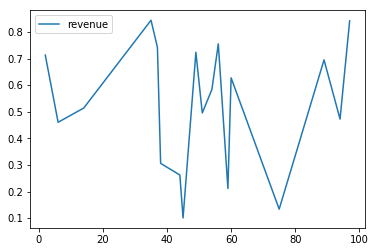

In [15]:
aht_trades.plot()

In [16]:
from pymongo import MongoClient

trade_db = MongoClient().trades